In [ ]:
!pip install transformers
!pip install datasets

#data analysis and processing

In [ ]:
from zipfile import ZipFile
import seaborn as sns
from sklearn.model_selection import train_test_split




import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader

from PIL import Image

import os
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import albumentations as A
import plotly.express as px
from albumentations.pytorch import ToTensorV2
from PIL import Image
import albumentations as album
import numpy as np
import plotly.graph_objects as go
import hashlib



## data load


In [ ]:
#get the kaggle token from kaggle settings and upload it
#upload the token from kaggle
from google.colab import files
files.upload()


Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"rabeeqasem","key":"cb9147fcdade3b1dbd6b8f299dd3b5ba"}'}

In [ ]:
os.environ['KAGGLE_CONFIG_DIR']='/content'

In [ ]:
## Download the dataset from the kaggle api command
!kaggle datasets download -d emmarex/plantdisease

plantdisease.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
#unzip the downloaded files
zip_name='/content/plantdisease.zip'
with ZipFile(zip_name, 'r') as zip:
  zip.extractall()
  print('done')


done


In [ ]:
#data set path
data_path='/content/PlantVillage'
os.chdir(data_path)

#EDA

In [ ]:

classes=list(os.listdir())
classes

['Tomato__Target_Spot',
 'Tomato_Late_blight',
 'Pepper__bell___healthy',
 'Potato___Late_blight',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Pepper__bell___Bacterial_spot',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Leaf_Mold',
 'Potato___healthy',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_healthy',
 'Potato___Early_blight']

In [ ]:
# Initialize a dictionary to store the count of images per class
class_counts = {}

# Count the number of images in each class
for class_name in classes:
    class_path = os.path.join(data_path, class_name)
    class_images = [f for f in os.listdir(class_path) ]  # Update with image extensions in your dataset
    class_counts[class_name] = len(class_images)

class_counts

{'Tomato__Target_Spot': 1404,
 'Tomato_Late_blight': 1909,
 'Pepper__bell___healthy': 1478,
 'Potato___Late_blight': 1000,
 'Tomato__Tomato_YellowLeaf__Curl_Virus': 3209,
 'Tomato_Spider_mites_Two_spotted_spider_mite': 1676,
 'Pepper__bell___Bacterial_spot': 997,
 'Tomato_Septoria_leaf_spot': 1771,
 'Tomato_Leaf_Mold': 952,
 'Potato___healthy': 152,
 'Tomato__Tomato_mosaic_virus': 373,
 'Tomato_Bacterial_spot': 2127,
 'Tomato_Early_blight': 1000,
 'Tomato_healthy': 1591,
 'Potato___Early_blight': 1000}

In [ ]:
# Convert class counts to a format suitable for Plotly
class_names = list(class_counts.keys())
class_values = list(class_counts.values())

# Create a bar plot using Plotly
fig = px.bar(x=class_names, y=class_values, labels={'x': 'Classes', 'y': 'Number of Images'},
             title='Class Distribution', text=class_values)

# Create a list of colors based on the condition
colors = ['red' if value <= 1000 else 'blue' for value in class_values]

# Update trace colors
fig.update_traces(marker_color=colors)

fig.update_layout(xaxis={'categoryorder': 'total descending'})
fig.show()

In [ ]:
#lets create a dataframe that have all the information that we have on the images the image path and the class

dataframe_list=[]
for index,c in enumerate(classes):
  for imag_name in list(os.listdir(os.path.join(data_path,c))):
    image_path=os.path.join(os.path.join(data_path,c,imag_name))
    photo_format=image_path.split('.')
    if photo_format[-1] in ['JPG','jpg','jpeg','png']:
      dataframe_list.append([image_path,photo_format[-1],index,c])

datainf=pd.DataFrame(dataframe_list,columns=['image_path','photo_format','label_id','class'])


In [ ]:
datainf.head()

image_path photo_format  label_id  \
0  /content/PlantVillage/Tomato__Target_Spot/b139...          JPG         0   
1  /content/PlantVillage/Tomato__Target_Spot/c6fc...          JPG         0   
2  /content/PlantVillage/Tomato__Target_Spot/d883...          JPG         0   
3  /content/PlantVillage/Tomato__Target_Spot/3015...          JPG         0   
4  /content/PlantVillage/Tomato__Target_Spot/841b...          JPG         0   

                 class  
0  Tomato__Target_Spot  
1  Tomato__Target_Spot  
2  Tomato__Target_Spot  
3  Tomato__Target_Spot  
4  Tomato__Target_Spot

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Define the color numbers
color_numbers = ['60d394', 'ffd97d','ee6055']

# Convert color numbers to RGB values
colors_rgb = [tuple(int(color[i:i+2], 16) for i in (0, 2, 4)) for color in color_numbers]

# Initialize counters for each type of plant
tomato_count = 0
potato_count = 0
pepper_count = 0

# Separate data for each type of plant
for class_name in classes:
    if 'Tomato' in class_name:
        tomato_count += class_counts[class_name]
    elif 'Potato' in class_name:
        potato_count += class_counts[class_name]
    elif 'Pepper' in class_name:
        pepper_count += class_counts[class_name]

# Create a pie chart for the distribution of plant types
plant_type_fig = go.Figure()

plant_type_fig.add_trace(
    go.Pie(
        labels=['Tomato', 'Potato', 'Pepper'],
        values=[tomato_count, potato_count, pepper_count],
        textinfo='percent+label',
        hole=0.3,
        marker=dict(colors=colors_rgb)  # Use the RGB colors here
    )
)

plant_type_fig.update_layout(
    title='Distribution of Plant Types',
    annotations=[dict(text='Plant Types', x=0.5, y=0.5, font_size=20, showarrow=False)]
)

plant_type_fig.show()


In [ ]:
datainf['photo_format'].value_counts()


JPG     20482
jpg       154
jpeg        1
png         1
Name: photo_format, dtype: int64

In [ ]:
import plotly.express as px

# Count the occurrences of each photo format
photo_format_counts = datainf['photo_format'].value_counts()

# Create a pie chart for the distribution of photo formats
photo_format_fig = px.pie(
    names=photo_format_counts.index,
    values=photo_format_counts.values,
    title='Distribution of Photo Formats',
    hole=0.3,  # Donut hole size
    labels={'names': 'Photo Format', 'values': 'Count'},
)

photo_format_fig.update_traces(
    insidetextorientation='horizontal',  # Adjust text label orientation
)

photo_format_fig.show()


In [ ]:

# Initialize counters for classes with and without viruses
with_virus_count = 0
without_virus_count = 0

# Separate data for classes with and without viruses
for class_name in classes:
    if 'healthy' in class_name:
        without_virus_count += class_counts[class_name]
    else:
        with_virus_count += class_counts[class_name]

# Create a horizontal bar chart for the count of plants with and without viruses
fig_with_vs_without = go.Figure()

fig_with_vs_without.add_trace(
    go.Bar(
        y=['With Virus'],
        x=[with_virus_count],
        orientation='h',
        name='With Virus',
        marker=dict(color='darkred')
    )
)

fig_with_vs_without.add_trace(
    go.Bar(
        y=['Without Virus'],
        x=[without_virus_count],
        orientation='h',
        name='Without Virus',
        marker=dict(color='green')
    )
)

fig_with_vs_without.update_layout(
    title='Distribution of Plants with and without Viruses',
    yaxis_title='Plant Status'
)



In [ ]:
import plotly.graph_objects as go

# Initialize counters for classes with and without viruses
with_virus_count = 0
without_virus_count = 0

# Separate data for classes with and without viruses
for class_name in classes:
    if 'healthy' in class_name:
        without_virus_count += class_counts[class_name]
    else:
        with_virus_count += class_counts[class_name]

# Create a bar chart for each plant class
fig_tomato = go.Figure()
fig_potato = go.Figure()
fig_pepper = go.Figure()

for class_name in classes:
    class_count = class_counts[class_name]
    if 'Tomato' in class_name:
        fig_tomato.add_trace(
            go.Bar(
                x=[class_name],
                y=[class_count],
                name=class_name
            )
        )
    elif 'Potato' in class_name:
        fig_potato.add_trace(
            go.Bar(
                x=[class_name],
                y=[class_count],
                name=class_name
            )
        )
    elif 'Pepper' in class_name:
        fig_pepper.add_trace(
            go.Bar(
                x=[class_name],
                y=[class_count],
                name=class_name
            )
        )

# Update layout for each chart
def update_layout(fig, title):
    fig.update_layout(
        title=title,
        xaxis_title='Plant Class',
        yaxis_title='Number of Plants'
    )

update_layout(fig_tomato, 'Number of Plants in Tomato Classes')
update_layout(fig_potato, 'Number of Plants in Potato Classes')
update_layout(fig_pepper, 'Number of Plants in Pepper Classes')

# Show the charts
fig_tomato.show()
fig_potato.show()
fig_pepper.show()


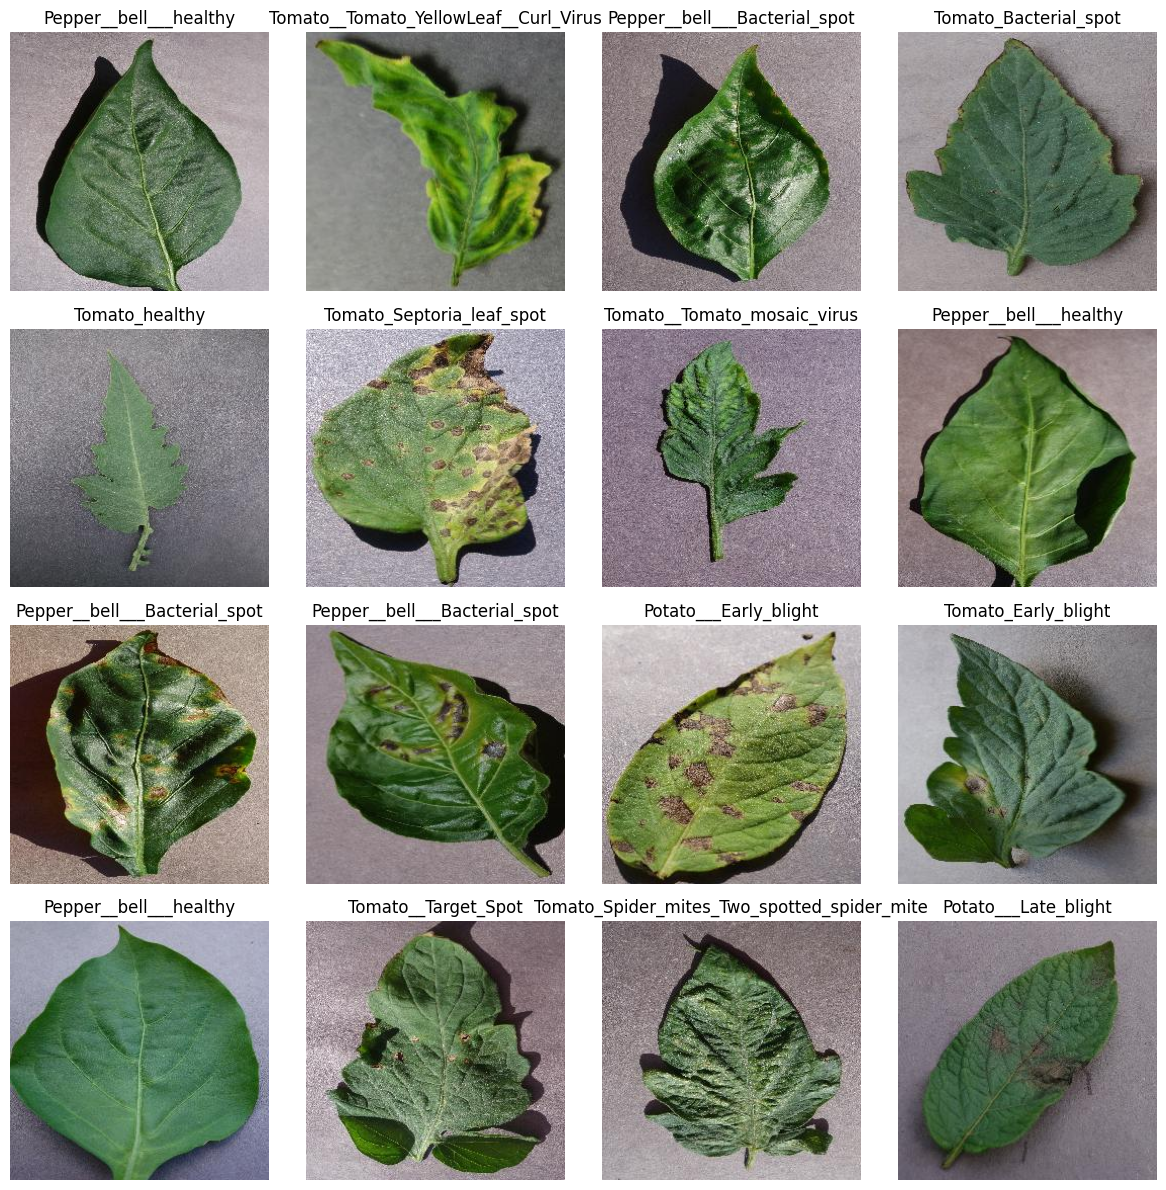

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# Define the data set path
data_path = '/content/PlantVillage'

# Get a list of all folder names within the data path
folder_names = os.listdir(data_path)

# Create a 4x4 subplot grid
num_rows = 4
num_cols = 4
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))

# Loop through each row and column of the subplot grid
for i in range(num_rows):
    for j in range(num_cols):
        # Randomly select a folder from the list
        selected_folder = random.choice(folder_names)

        # Get a list of image filenames within the selected folder
        folder_path = os.path.join(data_path, selected_folder)
        image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        # Randomly select an image from the list
        selected_image = random.choice(image_files)

        # Load and display the selected image in the current subplot
        img_path = os.path.join(folder_path, selected_image)
        img = mpimg.imread(img_path)
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        axes[i, j].set_title(selected_folder)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


data preprocessing

In [ ]:
## data preprocessing
from PIL import Image
import hashlib
import os

def calculate_hash(image_path):
    with open(image_path, 'rb') as f:
        image_data = f.read()
        return hashlib.md5(image_data).hexdigest()

def find_duplicate_images(class_folder):
    hash_to_image = {}
    duplicates = []

    for root, dirs, files in os.walk(class_folder):
        for file in files:
            image_path = os.path.join(root, file)
            image_hash = calculate_hash(image_path)

            if image_hash in hash_to_image:
                duplicates.append((hash_to_image[image_hash], image_path))
            else:
                hash_to_image[image_hash] = image_path

    return duplicates

def remove_duplicate_images(duplicates):
    for duplicate_pair in duplicates:
        image1_path, image2_path = duplicate_pair
        print(f"Removing duplicate: {image2_path}")
        os.remove(image2_path)

def display_duplicate_pairs(duplicates):
    for index, (image1_path, image2_path) in enumerate(duplicates, start=1):
        print(f"Duplicate pair {index}:")
        print(f"Image 1: {image1_path}")
        print(f"Image 2: {image2_path}")
        print("-" * 20)


#standardized_dir = r'C:\Users\mqendah\PycharmProjects\Smart plant disease detector\SmartPlantDiseaseDetector_Website\standardized_images'
#class_folders = [os.path.join(standardized_dir, d) for d in os.listdir(standardized_dir) if os.path.isdir(os.path.join(standardized_dir, d))]

for class_folder in classes:
    print(f"Searching for duplicates in {class_folder}")
    duplicates = find_duplicate_images(class_folder)

    if duplicates:
        print(f"Found {len(duplicates)} duplicate image pairs.")
        display_duplicate_pairs(duplicates)
        remove_duplicate_images(duplicates)
    else:
        print("No duplicate images found.")
        print("=" * 40)



Searching for duplicates in Tomato__Target_Spot
No duplicate images found.
Searching for duplicates in Tomato_Late_blight
Found 8 duplicate image pairs.
Duplicate pair 1:
Image 1: Tomato_Late_blight/bd4f09bd-ee85-4ab1-bce0-8cde3fdd7f1b___GHLB_PS Leaf 23.7 Day 13.jpg
Image 2: Tomato_Late_blight/48c55974-9fe9-4f4b-94f7-c8cd127d1e05___GHLB_PS Leaf 23.7 Day 13.jpg
--------------------
Duplicate pair 2:
Image 1: Tomato_Late_blight/c1775bad-7c02-41fb-bb7d-f8df91d60ac3___GHLB_PS Leaf 23.5 Day 13.jpg
Image 2: Tomato_Late_blight/98586693-fe1f-4ea0-8e27-4501b61cf09b___GHLB_PS Leaf 23.5 Day 13.jpg
--------------------
Duplicate pair 3:
Image 1: Tomato_Late_blight/2c47b891-3c97-48f1-a2cc-5aa53d3a1148___GHLB2 Leaf 9011.JPG
Image 2: Tomato_Late_blight/1a69b38b-c4eb-42c4-9584-bcb14fb8db0c___GHLB2 Leaf 9011.JPG
--------------------
Duplicate pair 4:
Image 1: Tomato_Late_blight/5688ea99-c949-41d0-bbab-9cbf0ffb8bcd___GHLB2 Leaf 8677.JPG
Image 2: Tomato_Late_blight/e20107e7-137f-400e-817f-5dc4c58e5d70___

In [ ]:
class_counts


{'Tomato__Target_Spot': 1404,
 'Tomato_Late_blight': 1909,
 'Pepper__bell___healthy': 1478,
 'Potato___Late_blight': 1000,
 'Tomato__Tomato_YellowLeaf__Curl_Virus': 3209,
 'Tomato_Spider_mites_Two_spotted_spider_mite': 1676,
 'Pepper__bell___Bacterial_spot': 997,
 'Tomato_Septoria_leaf_spot': 1771,
 'Tomato_Leaf_Mold': 952,
 'Potato___healthy': 152,
 'Tomato__Tomato_mosaic_virus': 373,
 'Tomato_Bacterial_spot': 2127,
 'Tomato_Early_blight': 1000,
 'Tomato_healthy': 1591,
 'Potato___Early_blight': 1000}

In [ ]:
# Initialize a dictionary to store the count of images per class
class_counts_after_delete = {}

# Count the number of images in each class
for class_name in classes:
    class_path = os.path.join(data_path, class_name)
    class_images = [f for f in os.listdir(class_path) ]  # Update with image extensions in your dataset
    class_counts_after_delete[class_name] = len(class_images)

In [ ]:
class_counts_after_delete

{'Tomato__Target_Spot': 1404,
 'Tomato_Late_blight': 1901,
 'Pepper__bell___healthy': 1478,
 'Potato___Late_blight': 1000,
 'Tomato__Tomato_YellowLeaf__Curl_Virus': 3209,
 'Tomato_Spider_mites_Two_spotted_spider_mite': 1676,
 'Pepper__bell___Bacterial_spot': 997,
 'Tomato_Septoria_leaf_spot': 1771,
 'Tomato_Leaf_Mold': 952,
 'Potato___healthy': 152,
 'Tomato__Tomato_mosaic_virus': 373,
 'Tomato_Bacterial_spot': 2127,
 'Tomato_Early_blight': 1000,
 'Tomato_healthy': 1585,
 'Potato___Early_blight': 1000}

In [ ]:
# Create a list of class names
class_names = list(class_counts.keys())

# Create a list of class counts before and after deletion
counts_before_delete = list(class_counts.values())
counts_after_delete = list(class_counts_after_delete.values())

# Create a list to mark changed classes
changed_classes = [1 if counts_before_delete[i] != counts_after_delete[i] else 0 for i in range(len(class_names))]

# Create traces for the grouped bar chart
trace_before_delete = go.Bar(x=class_names, y=counts_before_delete, name='Before Delete',
                             marker_color='rgba(31, 119, 180, 0.7)')  # Blue color
trace_after_delete = go.Bar(x=class_names, y=counts_after_delete, name='After Delete',
                            marker_color=['rgba(255, 127, 14, 0.7)' if changed else 'rgba(44, 160, 44, 0.7)' for changed in changed_classes])  # Orange for changed, Green for unchanged

# Create layout
layout = go.Layout(
    title='Class Counts Before and After Deletion',
    xaxis=dict(title='Class'),
    yaxis=dict(title='Count'),
    barmode='group'
)

# Create figure
fig = go.Figure(data=[trace_before_delete, trace_after_delete], layout=layout)

# Show the plot
fig.show()

data preprocessing

In [ ]:
train_df, test_df = train_test_split(datainf, test_size=0.2, random_state=42)
train_df,val_df = train_test_split(train_df, test_size=0.125, random_state=42)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the sizes of train, test, and validation sets
total_samples = len(datainf)
train_size = len(train_df)
test_size = len(test_df)
val_size = len(val_df)

# Calculate the percentages
train_percent = (train_size / total_samples) * 100
test_percent = (test_size / total_samples) * 100
val_percent = (val_size / total_samples) * 100

# Data for the pie chart
sizes = [train_percent, test_percent, val_percent]
labels = ['Train', 'Test', 'Validation']


In [ ]:
import plotly.express as px

# Data for the donut chart
sizes = [train_percent, test_percent, val_percent]
labels = ['Train', 'Test', 'Validation']

# Create a donut chart using Plotly
fig = px.pie(values=sizes, names=labels, title='Dataset Split Proportions',
             hole=0.4)  # Setting the hole parameter creates a donut chart

# Show the donut chart
fig.show()


Data Transofmation

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class ImageClassificationDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data.iloc[idx, 0]
        label = self.data.iloc[idx, 2]

        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)
        else:
            # Apply default transformation if transform is not provided
            default_transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
            ])
            image = default_transform(image)

        return image, label




In [ ]:
from torchvision import transforms


#appling the data agumentation on the training dataset
training_transform_function = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),  # Set a non-zero value here
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomPerspective(),
])

# transform_function=transforms.Compose([
#     transforms.Resize((224, 244)),
#     transforms.ToTensor(),
# ])

train_dataset = ImageClassificationDataset(train_df, transform=training_transform_function)
val_dataset = ImageClassificationDataset(val_df)
test_dataset = ImageClassificationDataset(test_df)

# Create DataLoader instances for training, validation, and testing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)


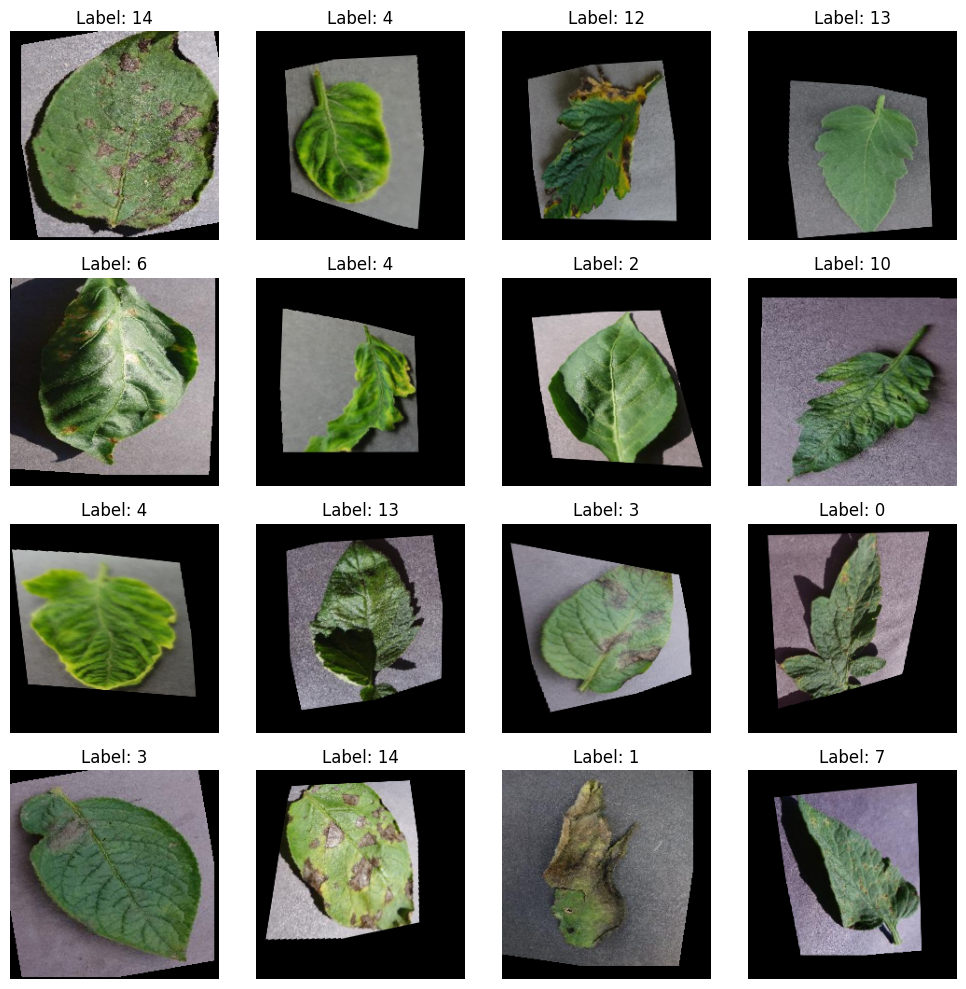

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

# Assuming you have already defined train_loader from your code

# Fetch a batch of images from the DataLoader
batch = next(iter(train_loader))
images, labels = batch

# Create a grid for displaying images
grid_size = (4, 4)
fig, axs = plt.subplots(*grid_size, figsize=(10, 10))

for i in range(grid_size[0]):
    for j in range(grid_size[1]):
        index = i * grid_size[1] + j
        image = images[index].permute(1, 2, 0).numpy()  # Convert tensor to numpy and rearrange channels
        label = labels[index].item()

        axs[i, j].imshow(image)
        axs[i, j].set_title(f"Label: {label}")
        axs[i, j].axis("off")

plt.tight_layout()
plt.show()

# data modeling and evaluation

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
from transformers import SegformerFeatureExtractor, SegformerForImageClassification,SegformerConfig
from PIL import Image
import requests

configuration = SegformerConfig()
#feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/mit-b5")
segformer_model = SegformerForImageClassification(configuration).from_pretrained("nvidia/mit-b5")
segformer_optimizer = torch.optim.AdamW(segformer_model.parameters(), lr=0.0001)
segformer_model.to(device)


SegformerForImageClassification(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)


In [ ]:
from transformers import ResNetConfig, ResNetForImageClassification
configuration = ResNetConfig()
resnet_model=ResNetForImageClassification(configuration).from_pretrained('microsoft/resnet-152')
resnet_optimizer = torch.optim.AdamW(resnet_model.parameters(), lr=0.0001)
resnet_model.to(device)


ResNetForImageClassification(
  (resnet): ResNetModel(
    (embedder): ResNetEmbeddings(
      (embedder): ResNetConvLayer(
        (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
      (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (encoder): ResNetEncoder(
      (stages): ModuleList(
        (0): ResNetStage(
          (layers): Sequential(
            (0): ResNetBottleNeckLayer(
              (shortcut): ResNetShortCut(
                (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (normalization): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (layer): Sequential(
                (0): ResNetConvLayer(
                  (convolution): Conv2d(64

In [ ]:
from transformers import PvtConfig, PvtForImageClassification
configuration = PvtConfig()
vit_model=PvtForImageClassification(configuration).from_pretrained('Zetatech/pvt-tiny-224')
vit_optimizer = torch.optim.AdamW(vit_model.parameters(), lr=0.0001)
vit_model.to(device)


PvtForImageClassification(
  (pvt): PvtModel(
    (encoder): PvtEncoder(
      (patch_embeddings): ModuleList(
        (0): PvtPatchEmbeddings(
          (projection): Conv2d(3, 64, kernel_size=(4, 4), stride=(4, 4))
          (layer_norm): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (1): PvtPatchEmbeddings(
          (projection): Conv2d(64, 128, kernel_size=(2, 2), stride=(2, 2))
          (layer_norm): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (2): PvtPatchEmbeddings(
          (projection): Conv2d(128, 320, kernel_size=(2, 2), stride=(2, 2))
          (layer_norm): LayerNorm((320,), eps=1e-06, elementwise_affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (3): PvtPatchEmbeddings(
          (projection): Conv2d(320, 512, kernel_size=(2, 2), stride=(2, 2))
          (layer_norm): LayerNorm((512,),

In [ ]:
from transformers import SwinConfig, SwinForImageClassification
configuration = SwinConfig()
swin_model=SwinForImageClassification(configuration).from_pretrained('microsoft/swin-tiny-patch4-window7-224')
swin_optimizer = torch.optim.AdamW(swin_model.parameters(), lr=0.0001)
swin_model.to(device)


SwinForImageClassification(
  (swin): SwinModel(
    (embeddings): SwinEmbeddings(
      (patch_embeddings): SwinPatchEmbeddings(
        (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): SwinEncoder(
      (layers): ModuleList(
        (0): SwinStage(
          (blocks): ModuleList(
            (0-1): 2 x SwinLayer(
              (layernorm_before): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
              (attention): SwinAttention(
                (self): SwinSelfAttention(
                  (query): Linear(in_features=96, out_features=96, bias=True)
                  (key): Linear(in_features=96, out_features=96, bias=True)
                  (value): Linear(in_features=96, out_features=96, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                )
                (output): SwinSelfOutput(
  

In [ ]:
from datasets import load_metric
import torch
import torch.nn as nn

from sklearn.metrics import precision_score, recall_score, f1_score

# Load the accuracy metric
metric = load_metric("accuracy")

# Define the number of epochs
num_epochs = 20

# Loss function
loss_function = nn.CrossEntropyLoss()

# Lists to store results
results = []

# Models to train
models = [
    {"name": "Vit", "model": vit_model, "optimizer": vit_optimizer},
     {"name": "swin", "model": swin_model, "optimizer": swin_optimizer},
    {"name": "Segformer", "model": segformer_model, "optimizer": segformer_optimizer},
    {"name": "ResNet", "model": resnet_model, "optimizer": resnet_optimizer},


]

# Training loop
for model_info in models:
    for epoch in range(num_epochs):

        model_name = model_info["name"]
        model = model_info["model"]
        optimizer = model_info["optimizer"]

        model.train()
        total_loss = 0.0
        total_correct = 0
        total_samples = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)

            # Calculate loss
            loss = loss_function(outputs.logits, labels)

            # Backpropagation
            loss.backward()
            optimizer.step()

            # Update metrics
            total_loss += loss.item()
            _, predicted = torch.max(outputs.logits, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

        # Calculate metrics for the epoch
        epoch_loss = total_loss / len(train_loader)
        epoch_accuracy = total_correct / total_samples

        # Print epoch results

        print(f"model_name [{model_name}], Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")


        # Validation loop
        model.eval()
        val_correct = 0
        val_samples = 0

        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            with torch.no_grad():
                outputs = model(images)

            _, predicted = torch.max(outputs.logits, 1)
            val_correct += (predicted == labels).sum().item()
            val_samples += labels.size(0)

        val_accuracy = val_correct / val_samples

        print(f"model: {model_name}, epoch: {epoch + 1}, train_accuracy: {epoch_accuracy}, val_accuracy: {val_accuracy}")
        # ...

    # Test loop
    model.eval()
    test_correct = 0
    test_samples = 0


    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        with torch.no_grad():
            outputs = model(images)

        _, predicted = torch.max(outputs.logits, 1)
        test_correct += (predicted == labels).sum().item()
        test_samples += labels.size(0)

    precision = precision_score(labels.cpu(), predicted.cpu(), average='weighted')
    recall = recall_score(labels.cpu(), predicted.cpu(), average='weighted')
    f1 = f1_score(labels.cpu(), predicted.cpu(), average='weighted')

    test_accuracy = test_correct / test_samples
    print(f"model_name:{model_name} Test Accuracy: {test_accuracy:.4f} precision: {precision:.4f}, recall: {recall:.4f}, f1: {f1:.4f}")
    print('-----------------------------------------------------------')

    #results.append({"model": model_name, "epoch": epoch + 1, "train_accuracy": epoch_accuracy, "val_accuracy": val_accuracy,"test_accuracy":test_accuracy})
    results.append({
    "model": model_name,
    "epoch": epoch + 1,
    "train_accuracy": epoch_accuracy,
    "val_accuracy": val_accuracy,
    "test_accuracy": test_accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1
})
    torch.cuda.empty_cache()



<ipython-input-23-f42019990657>:8: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


model_name [Vit], Epoch [1/20] - Loss: 0.4251, Accuracy: 0.8792
model: Vit, epoch: 1, train_accuracy: 0.8792053163505469, val_accuracy: 0.9583333333333334
model_name [Vit], Epoch [2/20] - Loss: 0.1022, Accuracy: 0.9651
model: Vit, epoch: 2, train_accuracy: 0.9651114495362038, val_accuracy: 0.9772286821705426
model_name [Vit], Epoch [3/20] - Loss: 0.0737, Accuracy: 0.9760
model: Vit, epoch: 3, train_accuracy: 0.9760487332133463, val_accuracy: 0.9844961240310077
model_name [Vit], Epoch [4/20] - Loss: 0.0579, Accuracy: 0.9812
model: Vit, epoch: 4, train_accuracy: 0.981171258479856, val_accuracy: 0.9588178294573644
model_name [Vit], Epoch [5/20] - Loss: 0.0473, Accuracy: 0.9847
model: Vit, epoch: 5, train_accuracy: 0.984701647514883, val_accuracy: 0.9840116279069767
model_name [Vit], Epoch [6/20] - Loss: 0.0488, Accuracy: 0.9839
model: Vit, epoch: 6, train_accuracy: 0.9838709677419355, val_accuracy: 0.9849806201550387
model_name [Vit], Epoch [7/20] - Loss: 0.0492, Accuracy: 0.9839
model: V

In [ ]:
results

In [ ]:
# Assuming 'results' is a list of dictionaries containing the result data
data = []
for result in results:
  data.append({
        "Model": result["model"],
        "Epoch": result["epoch"],
        "Train Accuracy": result["train_accuracy"],
        "Validation Accuracy": result["val_accuracy"],
        "Test Accuracy":result["test_accuracy"],
        "loss":result["loss"]

    })

# Create a DataFrame from the data
df = pd.DataFrame(data)

In [ ]:
df

Model  Epoch  Train Accuracy  Validation Accuracy  Test Accuracy  \
0        Vit     20        0.991970             0.971899       0.971899   
1       swin     20        0.991762             0.993702       0.993702   
2  Segformer     20        0.993978             0.987888       0.986919   
3     ResNet     20        0.994739             0.987403       0.990310   

     loss  
0  0.0234  
1  0.0283  
2  0.0208  
3  0.0158

In [ ]:
#save the model to my drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
torch.save(swin_model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/hackathon/swim.pth')

In [ ]:
torch.save(resnet_model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/hackathon/swim.pth')

In [ ]:
predict_model = torch.load('/content/drive/My Drive/swim.pth')

#Test the model

In [ ]:
data_path='/content'
os.chdir(data_path)

In [ ]:
from google.colab import files
files.upload()

In [ ]:
# Read the JPEG photo
image =Image.open('/content/1dcfeaa9-006d-470c-b3e5-d67609d07d4e___RS_HL 1808.JPG').convert("RGB")

# Define a transform to resize the image to 64x64
predict_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Convert the image to a tensor
img_tensor = predict_transform(image).unsqueeze(dim=0).to(device)
outputs=resnet_model(img_tensor)

_, predicted = torch.max(outputs.logits, 1)
classes[int(predicted)]